## Imports

In [1]:
import scipy.optimize as opt
import numpy as np
import matplotlib.pylab as plt
from tifffile import imread
from scipy.ndimage.filters import gaussian_filter
import csv
import matplotlib.animation as animation

from pathlib import Path

## Functions

In [152]:
def gauss_2D(xy_tuple, A, x_0, y_0, sigma_x, sigma_y, theta, C):

    (x,y) = xy_tuple
    x_0 = float(x_0)
    y_0 = float(y_0)

    cos_theta_2 = np.cos(theta)**2
    sin_theta_2 = np.sin(theta)**2
    cos_2_theta = np.cos(2*theta)
    sin_2_theta = np.sin(2*theta)

    sigma_x_2 = sigma_x**2
    sigma_y_2 = sigma_y**2

    a = cos_theta_2/(2*sigma_x_2) + sin_theta_2/(2*sigma_y_2)
    b = -sin_2_theta/(4*sigma_x_2) + sin_2_theta/(4*sigma_y_2)
    c = sin_theta_2/(2*sigma_x_2) + cos_theta_2/(2*sigma_y_2)

    gauss = A*np.exp(-(a*(x-x_0)**2 + 2*b*(x-x_0)*(y-y_0) + c*(y-y_0)**2)) + C
    
    return gauss.ravel()


def double_gauss_2D(xy_tuple, A, x_0, y_0, sigma_x, sigma_y, theta,
                    A_, x_0_, y_0_, sigma_x_, sigma_y_, theta_, C):

    gauss = gauss_2D(xy_tuple, A, x_0, y_0, sigma_x, sigma_y, theta, 0)
    gauss_ = gauss_2D(xy_tuple, A_, x_0_, y_0_, sigma_x_, sigma_y_, theta_, 0)
    
    return gauss + gauss_ + C

def diff_of_gauss(xy_tuple, A, x_0, y_0, sigma_x, sigma_y, theta,
                  A_, x_0_, y_0_, sigma_x_, sigma_y_, theta_, C):
    gauss = gauss_2D(xy_tuple, A, x_0, y_0, sigma_x, sigma_y, theta, 0)
    gauss_ = gauss_2D(xy_tuple, A_, x_0_, y_0_, sigma_x_, sigma_y_, theta_, 0)
    
    return gauss - gauss_ + C


def sum_squared_residuals(coords, real_vals, *params):
    num_params = len(params)
    
    if num_params==7:
        fitted = gauss_2D(coords, *params)
    else:
        fitted = double_gauss_2D(coords, *params)
        
    residuals = fitted - real_vals
    
    sum_squared_residuals = 0;
    
    for r in residuals:
        sum_squared_residuals += r**2
        
    return sum_squared_residuals


def euclidean_distance(c1, c2):
    x1 = c1[0];
    y1 = c1[1];
    x2 = c2[0];
    y2 = c2[1];
    
    return ((x1-x2)**2 + (y1-y2)**2)**0.5

def randomise_initial_conditions_and_fit(coords, real_vals, iterations, params):
    best_residual = np.inf
    
    for i in range(iterations):
        
        for p in range(len(params)):
            original_param = params[p]
            params[p] = np.random.normal(original_param, max(0.01, 0.05*original_param))
                    
        try:
            popt_double, pcov_double = opt.curve_fit(double_gauss_2D, coords, real_vals, p0=params)
        except:
            continue
                
        residual = sum_squared_residuals(coords, real_vals, *popt_double)
        
        if residual<best_residual:
            best_residual = residual
            best_params = popt_double
        
    return best_params

## Load image

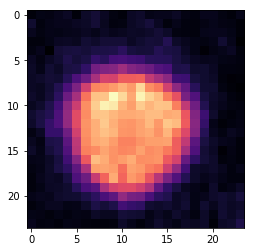

In [219]:
# path of image to import
f = r'\\128.40.81.191\data from collaborators\SaricLab\Two_colour_data\results - two-colour\crops_190828_WT_NR_DNA_PAD_2_MMStack_Pos0.ome\tifs\190828_WT_NR_DNA_PAD_2_MMStack_Pos0.ome_crop_003.tif'

# read image data
T = imread(str(f))
if T.shape[1]==2:
    T = T[:,0,:,:]

# set frame to analyse
frame = 5

# preview frame
plt.figure()
plt.imshow(T[frame], cmap=plt.cm.magma)

## Crop image to cell of interest

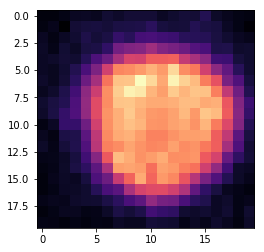

In [221]:
# specify x and y centres (approximate) from plot above
centre_x = 10
centre_y = 13

# specify radius of box to crop around (should contain entire cell)
box_radius = 10

# making sure that cropped area doesn't extend past image boundaries
dims = T[frame].shape
h = dims[0]
w = dims[1]

x_start = max(0, centre_x-box_radius)
x_end = min(w-1, centre_x+box_radius)

y_start = max(0, centre_y-box_radius)
y_end = min(h-1, centre_y+box_radius)

# crop and show
cropped_data = T[frame][y_start:y_end, x_start:x_end]
plt.imshow(cropped_data, cmap=plt.cm.magma)

## Fitting

In [222]:
# get (x,y) coordinates for fitting
indices = np.indices(cropped_data.shape)

# estimate initial conditions for 2d gaussian fit
dims_crop = cropped_data.shape
h_crop = dims_crop[0]
w_crop = dims_crop[1]

A = cropped_data[box_radius, box_radius]
sigma = box_radius/2
C = np.mean([cropped_data[0, 0], cropped_data[h_crop-1,0], cropped_data[0, w_crop-1], cropped_data[h_crop-1,w_crop-1]])

p0=[A, box_radius, box_radius, sigma, sigma, 0, C]
print(f'initial conditions for 2d gaussian fitting: {p0}\n')

# do 2d gaussian fit to data
try:
    popt_single, pcov_single = opt.curve_fit(gauss_2D, indices, cropped_data.ravel(), p0=p0)
except:
    # if fit is terrible, smooth data and try again
    popt_single, pcov_single = opt.curve_fit(gauss_2D, indices, gaussian_filter(cropped_data, 1).ravel(), p0=p0)
 
A_ = popt_single[0]
x0 = popt_single[1]
y0 = popt_single[2]
sigma_x = popt_single[3]
sigma_y = popt_single[4]
theta = popt_single[5]
C = popt_single[6]

print(f'results of 2d gaussian fitting: \n\tamplitude = {A_} \n\tx0 = {x0} \n\ty0 = {y0} \n\tsigma_x = {sigma_x} \n\tsigma_y = {sigma_y} \n\ttheta = {theta} \n\tC = {C} \n')

# prepare initial conditions for difference fit
p0_diff=[1.5*A_, x0, y0, sigma_x, sigma_y, theta, A_, x0, y0, sigma_x-2, sigma_y-2, theta, C]

print(f'initial conditions for 2d gaussian difference fitting: {p0_diff}\n')

# do 2d gaussian difference fit to data
popt_diff, pcov_diff = opt.curve_fit(diff_of_gauss, indices, cropped_data.ravel(), p0=p0_diff, maxfev=10000)

A_out = popt_diff[0]
x0_out = popt_diff[1]
y0_out = popt_diff[2]
sigma_x_out = popt_diff[3]
sigma_y_out = popt_diff[4]
theta_out = popt_diff[5]
A_in = -popt_diff[6]
x0_in = popt_diff[7]
y0_in = popt_diff[8]
sigma_x_in = popt_diff[9]
sigma_y_in = popt_diff[10]
theta_in = popt_diff[11]
C_diff = popt_diff[12]

print(f'results of 2d gaussian difference fitting: \n\tamplitude outer = {A_out} \n\tx0 outer = {x0_out} \n\ty0 outer = {y0_out} \n\tsigma_x outer = {sigma_x_out} \n\tsigma_y outer = {sigma_y_out} \n\ttheta outer = {theta_out} \n\tamplitude inner = {A_in} \n\tx0 inner = {x0_in} \n\ty0 inner = {y0_in} \n\tsigma_x inner = {sigma_x_in} \n\tsigma_y inner = {sigma_y_in} \n\ttheta inner = {theta_in} \n\tC = {C_diff} \n')




initial conditions for 2d gaussian fitting: [331, 10, 10, 5.0, 5.0, 0, 142.75]

results of 2d gaussian fitting: 
	amplitude = 296.6285508958603 
	x0 = 9.443511833327738 
	y0 = 10.734969880061685 
	sigma_x = 5.502836555054107 
	sigma_y = 5.558941669357155 
	theta = -0.05341598536892741 
	C = 100.24103324402668 

initial conditions for 2d gaussian difference fitting: [444.94282634379044, 9.443511833327738, 10.734969880061685, 5.502836555054107, 5.558941669357155, -0.05341598536892741, 296.6285508958603, 9.443511833327738, 10.734969880061685, 3.502836555054107, 3.5589416693571554, -0.05341598536892741, 100.24103324402668]

results of 2d gaussian difference fitting: 
	amplitude outer = 97127.47324877822 
	x0 outer = 9.682622700083177 
	y0 outer = 10.807719942676258 
	sigma_x outer = 3.1182780123544784 
	sigma_y outer = 3.109697531404548 
	theta outer = -1.2932273405876833 
	amplitude inner = -96964.8433809189 
	x0 inner = 9.683370016081263 
	y0 inner = 10.807875939217983 
	sigma_x inner = 

## Plot fits

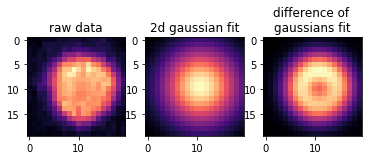

In [223]:
# create models from fits
imfit_single = gauss_2D(indices, *popt_single)
imfit_diff = diff_of_gauss(indices, *popt_diff)

# plot data and fitted models
fig, ax = plt.subplots(1,3)
ax[0].set_title('raw data')
ax[0].imshow(cropped_data, cmap = plt.cm.magma)
ax[1].set_title('2d gaussian fit')
ax[1].imshow(imfit_single.reshape(cropped_data.shape), cmap = plt.cm.magma)
ax[2].set_title('difference of \ngaussians fit')
ax[2].imshow(imfit_diff.reshape(cropped_data.shape), cmap = plt.cm.magma)